In [109]:
# Plan of Action
# plot all tackle distance data to determine methodology for picking playmaking threshold
    # Find distance between tackler and ball when ball carrier gets ball
# come up with cone of influence equation 
# distance delta pipeline


 #cone is where the defender could make the tackle

# ONLY LOOK AT RUN PLAYS FOR NOW
# Chase down efficiency
    # How well does each defender's cone move towards the ball carrier
        # Have a minimum distance to be able to be considered for the play
            # distribution of tackler's distance moved from play, get the upper quartile as the min distance
        # How do we judge how effectively they move there?
            # is it just distance delta?
                # consider derivative of distance over time as metric in concern
            # is it moving to final tackle location
            # is it cone overlap delta?

# Once cone overlap reaches threshold, chaser converts to prospective tackler
    # Use this to consider conversion rates for chasers

# Tackle probability - for all prospective tacklers
    # after ball carrier is in cone, how well does tackler make tackle
        # cone overlap integral
        # how fast does cone overlap area increase
        # 
##

#bivariate distribution - x is normally distributed, y is skewed distributed
# these distributions are centered on the player's location and have stdev of some formula of velocity and weight
#the combined distribution comes from multipying the x and y distribution because we're assuming independence


In [110]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import math
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from scipy.stats import t
from sklearn.preprocessing import StandardScaler

In [111]:
# Game info - id, week, date, time, teams, scores
games = pd.read_csv("games.csv")


In [112]:
plays = pd.read_csv("plays.csv")
plays['gameClockSeconds'] = pd.to_datetime(plays['gameClock'], format='%M:%S').dt.minute * 60 + pd.to_datetime(plays['gameClock'], format='%M:%S').dt.second
plays.sort_values(by=["gameId", "quarter", "gameClockSeconds"], ascending=[True, True, False], inplace=True)
# plays.head()
# print(plays[["gameId", "gameClockSeconds"]])
plays['penaltyYards'].fillna(0, inplace=True)
plays['passLength'].fillna(0, inplace=True)

plays['passResult'] = plays['passResult'].replace('R', 'Q')
plays['passResult'] = plays['passResult'].fillna('R')
print(plays['passResult'])
print(plays.columns)

4887     C
2817     Q
7698     R
6263     C
3625     R
        ..
11765    R
11617    R
1887     R
9336     R
1575     R
Name: passResult, Length: 12479, dtype: object
Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2',
       'gameClockSeconds'],
      dtype='object')


In [113]:
plays.drop("gameClock", axis=1, inplace=True)
plays.head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,gameClockSeconds
4887,2022090800,56,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,...,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN,900
2817,2022090800,80,46076,Josh Allen,"(14:29) (No Huddle, Shotgun) J.Allen scrambles...",1,2,4,BUF,LA,...,0.586684,-0.013497,0.013497,1.303119,0.823571,NaN,NaN,NaN,NaN,869
7698,2022090800,101,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,...,0.600181,-0.014850,0.014850,2.126690,0.562363,NaN,NaN,NaN,NaN,834
6263,2022090800,122,47857,Devin Singletary,(13:15) (Shotgun) J.Allen pass short right to ...,1,2,3,BUF,LA,...,0.615031,-0.019032,0.019032,2.689053,0.399209,NaN,NaN,NaN,NaN,795
3625,2022090800,146,47857,Devin Singletary,(12:33) (Shotgun) D.Singletary left tackle to ...,1,1,10,BUF,LA,...,0.634062,0.021616,-0.021616,3.088262,-0.514056,NaN,NaN,NaN,NaN,753


In [114]:
players = pd.read_csv("players.csv")
print(players.head())
players['birthDate'] = pd.to_datetime(players['birthDate'])
reference_date = dt(2022, 9, 8)
players['age'] = players['birthDate'].apply(lambda x: reference_date.year - x.year - ((reference_date.month, reference_date.day) < (x.month, x.day)))
players.drop('birthDate', axis = 1, inplace=True)
players.drop('collegeName', axis = 1, inplace=True)


   nflId height  weight  birthDate     collegeName position     displayName
0  25511  4-Jun     225   8/3/1977        Michigan       QB       Tom Brady
1  29550  4-Jun     328  1/22/1982        Arkansas        T    Jason Peters
2  29851  2-Jun     225  12/2/1983      California       QB   Aaron Rodgers
3  30842  6-Jun     267  5/19/1984            UCLA       TE  Marcedes Lewis
4  33084  4-Jun     217  5/17/1985  Boston College       QB       Matt Ryan


In [115]:
tackles = pd.read_csv("tackles.csv")
tackles.head()
missed_tackles = tackles[tackles['pff_missedTackle'] == 1]
tackles = tackles[tackles['pff_missedTackle'] != 1]

In [116]:
w1 = pd.read_csv("tracking_week_1.csv")
w2 = pd.read_csv("tracking_week_2.csv")
w3 = pd.read_csv("tracking_week_3.csv")
w4 = pd.read_csv("tracking_week_4.csv")
w5 = pd.read_csv("tracking_week_5.csv")
w6 = pd.read_csv("tracking_week_6.csv")
w7 = pd.read_csv("tracking_week_7.csv")
w8 = pd.read_csv("tracking_week_8.csv")
w9 = pd.read_csv("tracking_week_9.csv")

In [117]:
all_weeks = pd.concat([w1, w2, w3, w4, w5, w6, w7, w8, w9])
# all_weeks.head()
all_weeks['o'] = all_weeks['o'].apply(lambda theta: ((360 - theta) + 90) % 360)
all_weeks['dir'] = all_weeks['dir'].apply(lambda theta: ((360 - theta) + 90) % 360)
all_weeks.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,218.26,302.10,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,219.02,301.47,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,27.01,1.57,0.49,0.15,219.02,302.95,NaN
3,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,88.64,26.90,1.44,0.89,0.14,217.62,304.58,NaN
4,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,88.72,26.80,1.29,1.24,0.13,216.64,308.05,NaN


In [118]:
# want ballcarrier data for each play
# player name, player id, gameid, playid, x, y, s, etc. for all the moments that they have recieved the ball from the qb
temp = w1
temp.dropna(subset=['event'], inplace=True)
# Assuming your DataFrame is named df and contains the 'event' column

# Filtering to get rows where 'event' column doesn't contain 'pass', 'tackle', or 'contact'
filtered_events = temp[~temp['event'].str.contains('pass|tackle|contact', na=False, case=False)]['event']

# Displaying the unique filtered events
unique_filtered_events = filtered_events.unique()
print(unique_filtered_events)

#temp = temp[~temp['event'].str.contains('tackle', na=False)]['event']
# temp = temp[~temp['event'].str.contains('contact', na=False)]['event']
# type(w1.iloc[1,16])
w1[w1['event'] == 'run']
plays[plays["playId"] == 101][plays["gameId"] == 2022090800]

['run' 'ball_snap' 'handoff' 'touchdown' 'out_of_bounds' 'man_in_motion'
 'fumble' 'play_action' 'lateral' 'line_set' 'qb_slide' 'shift' 'qb_sack'
 'autoevent_ballsnap' 'snap_direct' 'fumble_defense_recovered'
 'fumble_offense_recovered']


C:\Users\theep\AppData\Local\Temp\ipykernel_13764\470345304.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plays[plays["playId"] == 101][plays["gameId"] == 2022090800]


,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,gameClockSeconds
7698,2022090800,101,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,...,0.600181,-0.01485,0.01485,2.12669,0.562363,NaN,NaN,NaN,NaN,834


In [119]:
#plays.head()
print(plays.columns)
plays.drop(columns=['quarter', 'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2', 'yardlineSide',
                    'passLength', 'penaltyYards', 'prePenaltyPlayResult', 'playNullifiedByPenalty',
                    'passProbability', 'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
                    'visitorTeamWinProbilityAdded'], inplace=True)

Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'preSnapHomeScore',
       'preSnapVisitorScore', 'passResult', 'passLength', 'penaltyYards',
       'prePenaltyPlayResult', 'playResult', 'playNullifiedByPenalty',
       'absoluteYardlineNumber', 'offenseFormation', 'defendersInTheBox',
       'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2',
       'gameClockSeconds'],
      dtype='object')


In [120]:
print(all_weeks['event'].unique())
print(all_weeks['event'].value_counts())
# print(all_weeks['event'].value_counts().get('handoff'))

[nan 'pass_arrived' 'pass_outcome_caught' 'tackle' 'run' 'first_contact'
 'ball_snap' 'handoff' 'touchdown' 'out_of_bounds' 'man_in_motion'
 'fumble' 'play_action' 'pass_forward' 'lateral' 'autoevent_passforward'
 'autoevent_passinterrupted' 'line_set' 'qb_slide' 'shift'
 'run_pass_option' 'qb_sack' 'pass_shovel' 'autoevent_ballsnap'
 'snap_direct' 'fumble_defense_recovered' 'fumble_offense_recovered'
 'penalty_flag' 'safety' 'pass_outcome_touchdown' 'penalty_accepted']
event
first_contact                242259
tackle                       230921
ball_snap                    145405
handoff                      135378
pass_outcome_caught          130087
pass_arrived                 113825
out_of_bounds                 41629
run                           21804
man_in_motion                  9683
touchdown                      9523
play_action                    6463
shift                          3358
qb_slide                       3158
fumble                         2415
pass_forward   

In [121]:
#calculate distance threshold
# array storing the distance from the tackler to the point of reception/handoff at the moment of play start
all_start_dists = []
# Stores tuple of (playId, gameId, start frame #, defensive team)
play_nums = []
for index, play in tackles.iterrows(): 
    current_game_id = play['gameId']
    current_play_id = play['playId']
    #filter to only run plays, filter current_play down to only tackler and ball_carrier to calculate the threshold
    if (plays[(plays['gameId'] == current_game_id) & (plays['playId'] == current_play_id)]['passResult'].values[0] != 'R'):
        continue
    tackler_id = play['nflId']
    ball_carrier_id = plays[(plays["gameId"] == current_game_id) & (plays["playId"] == current_play_id)]['ballCarrierId'].iloc[0]
    current_play = all_weeks[(all_weeks['gameId'] == current_game_id) & (all_weeks['playId'] == current_play_id)]
    current_play = current_play[(current_play["nflId"] == tackler_id) | (current_play["nflId"] == ball_carrier_id) | (current_play["displayName"] == 'football')]
    if ('tackle' not in current_play['event'].unique()):
        continue
    defensive_team = plays[(plays["gameId"] == current_game_id) & (plays["playId"] == current_play_id)]['defensiveTeam'].iloc[0]
    #get moment of handoff = startFrame
    curr_frame = pd.DataFrame()
    min_dist_positions = [-1, -1]

    if (current_play['event'] == 'handoff').any():
        curr_frame = current_play[current_play['event'] == 'handoff']
        start_frame = curr_frame['frameId'].iloc[0]
        min_dist_positions[0] = curr_frame[curr_frame['nflId'] == ball_carrier_id]['x'].iloc[0]
        min_dist_positions[1] = curr_frame[curr_frame['nflId'] == ball_carrier_id]['y'].iloc[0]
    
    else:
        min_dist = 100
        # saves the following at moment of reception/handoff: 
        #   [ball_carrier_x, ball_carrier_y]
        
        start_frame = -1
        # print("play: ", index)
        for i in range(1,max(current_play['frameId'])):
            curr_frame = current_play[current_play['frameId'] == i]
            ball_carrier_x = curr_frame[curr_frame['nflId'] == ball_carrier_id]['x'].iloc[0]
            ball_carrier_y = curr_frame[curr_frame['nflId'] == ball_carrier_id]['y'].iloc[0]
            football_x = curr_frame[curr_frame['displayName'] == 'football']['x'].iloc[0]
            football_y = curr_frame[curr_frame['displayName'] == 'football']['y'].iloc[0]
            
            dist = math.dist([ball_carrier_x, ball_carrier_y], [football_x, football_y])
            if dist < min_dist:
                min_dist = dist
                min_dist_positions[0] = ball_carrier_x
                min_dist_positions[1] = ball_carrier_y
                start_frame = i
                if dist < .4:
                    break
        #just ensure start_frame isn't too late

    
    #extract the startframe
    curr_frame = current_play[current_play['frameId'] == start_frame]
    curr_frame = curr_frame[curr_frame["nflId"] == tackler_id]
    tackler_x = curr_frame.iloc[0, 9]
    tackler_y = curr_frame.iloc[0, 10]
    tackler_distance = math.dist([min_dist_positions[0], min_dist_positions[1]], [tackler_x, tackler_y])
    b = (current_game_id, current_play_id, start_frame, defensive_team)
    all_start_dists.append(tackler_distance)
    if b not in play_nums:
        play_nums.append(b)

In [167]:
# After running previous cell, all_start_dists has all the distances from ball carrier to tackler at playstart
# for outlier using 1.5IQR + Q3 

all_start_dists = np.array(all_start_dists)

quartile_3 = np.percentile(all_start_dists, 75)
quartile_1 = np.percentile(all_start_dists, 25)

potential_tackler_threshold = quartile_3 + 1.5*(quartile_3  - quartile_1)
print(quartile_1, quartile_3, potential_tackler_threshold)

5.600062498882549 9.652761257867734 15.731809396345511


In [123]:
df = all_weeks.merge(plays, on=['gameId', 'playId'], how='inner')


In [124]:
valid = []

for game_id, play_id, start_frame, def_club in play_nums:
    # Selecting the plays and the right frames
    play_df = df[(df['gameId'] == game_id) & (df['playId'] == play_id) & (df['frameId'] >= start_frame)]

    # Filtering offensive players and football
    off_club = play_df[play_df['club'] != def_club]
    #getting start rows for defensive players
    start_frame_rows = play_df[(play_df['club'] == def_club) & (play_df['frameId'] == start_frame)]

    ball_carrier_name = start_frame_rows['ballCarrierDisplayName'].iloc[0]
    valid_player_names = [player for player in start_frame_rows['displayName'] if 
                          (math.dist([start_frame_rows[start_frame_rows['displayName'] == player]['x'].iloc[0], 
                                      start_frame_rows[start_frame_rows['displayName'] == player]['y'].iloc[0]],
                                     [off_club[off_club['displayName'] == ball_carrier_name]['x'].iloc[0], 
                                      off_club[off_club['displayName'] == ball_carrier_name]['y'].iloc[0]])
                          < potential_tackler_threshold)]
    def_club_filtered = play_df[play_df['displayName'].isin(valid_player_names)]
    valid.extend([off_club, def_club_filtered])


# Concatenate the results outside the loop
#valid_players_df = pd.concat(valid)


In [134]:
# valid_players is a subset of all_weeks and plays
valid_players = pd.concat(valid)

In [135]:
defensive_positions = ('DE', 'SS', 'FS', 'OLB', 'DT', 'CB', 'MLB')

defensive_players = []
for pos in defensive_positions:
    defensive_players.append(list(players[players['position'] == pos]
                                  .drop(columns=['height', 'weight', 'position', 'displayName', 'age'])['nflId']))


In [136]:
tackles_to_keep = []

for game_id, play_id, _, __ in play_nums:
    tackle = tackles[(tackles['gameId'] == game_id) & (tackles['playId'] == play_id)]
    tackles_to_keep.append(tackle)

tackles_for_stdev = pd.concat(tackles_to_keep)

tackles_for_stdev = tackles_for_stdev[['gameId', 'playId', 'nflId']]
tackles_for_stdev = tackles_for_stdev.merge(plays[['gameId', 'playId', 'ballCarrierId']], on=['gameId', 'playId'])
weeks_for_stdev = all_weeks[['gameId', 'playId', 'nflId', 'event', 'x', 'y', 'dir', 'playDirection']]
weeks_for_stdev = weeks_for_stdev[weeks_for_stdev['event'].isin(['tackle', 'out_of_bounds', 'fumble', 'qb_slide', 'safety'])]

In [137]:
defensive_distances_at_tackle = {'DE':([], []), 'SS':([], []), 'FS':([], []), 'OLB':([], []), 'DT':([], []), 'CB':([], []), 'MLB':([], [])}

for index, row in tackles_for_stdev.iterrows():
    game_id = row['gameId']
    play_id = row['playId']
    ball_carrier_id = row['ballCarrierId'] 
    tackler_id = row['nflId']
    
    curr_frame = weeks_for_stdev[(weeks_for_stdev['gameId'] == game_id) & (weeks_for_stdev['playId'] == play_id)]

    x_dist = curr_frame[curr_frame['nflId'] == ball_carrier_id]['x'].iloc[0] - curr_frame[curr_frame['nflId'] == tackler_id]['x'].iloc[0]
    y_dist = curr_frame[curr_frame['nflId'] == ball_carrier_id]['y'].iloc[0] - curr_frame[curr_frame['nflId'] == tackler_id]['y'].iloc[0]
    pos = players[players['nflId'] == tackler_id]['position'].iloc[0]
    
    if curr_frame['playDirection'].iloc[0] == 'right':
        x_dist = x_dist * -1

    theta = np.radians(curr_frame[curr_frame['nflId'] == tackler_id]['dir'].iloc[0])

    # Rotation matrix
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])

    # Apply rotation
    rotated_pair = np.dot(rotation_matrix, np.array([x_dist, y_dist]))

    # Extract rotated coordinates
    x_rotated, y_rotated = rotated_pair

    defensive_distances_at_tackle[pos][0].append(x_rotated)
    defensive_distances_at_tackle[pos][1].append(y_rotated)
    

In [138]:
def remove_outliers(x, y, z_threshold=3):
    # Convert to NumPy arrays
    x_arr, y_arr = np.array(x), np.array(y)

    # Calculate z-scores for distances
    distances = np.sqrt(x_arr**2 + y_arr**2)
    z_scores = np.abs((distances - np.mean(distances)) / np.std(distances))

    # Create a mask based on the z-score threshold
    mask = z_scores < z_threshold

    # Apply the mask to both x and y arrays
    return x_arr[mask], y_arr[mask]

# filtering tackle dist outliers
for index, (x_dists, y_dists) in defensive_distances_at_tackle.items():
    # Remove outliers
    print(index, len(x_dists), len(y_dists))
    filtered_x, filtered_y = remove_outliers(x_dists, y_dists)
    defensive_distances_at_tackle[index] = (filtered_x, filtered_y)

DE 1095 1095
DE 1077 1077
SS 693 693
SS 673 673
FS 701 701
FS 685 685
OLB 1420 1420
OLB 1390 1390
DT 1718 1718
DT 1687 1687
CB 796 796
CB 781 781
MLB 1715 1715
MLB 1688 1688


In [139]:
# Stores (mean, stdev) keyed by position
defensive_stats = {'DE':(0,0), 'SS':(0,0), 'FS':(0,0), 'OLB':(0,0), 'DT':(0,0), 'CB':(0,0), 'MLB':(0,0)}
position_t_info = {
    'DE': [],
    'SS': [],
    'FS': [],
    'OLB': [],
    'DT': [],
    'CB': [],
    'MLB': []
}
# Calculate mean and std for each key
for key, (x_dists, y_dists) in defensive_distances_at_tackle.items():
    mean_x = np.mean(x_dists)
    std_x = np.std(x_dists)
    mean_y = np.mean(y_dists)
    std_y = np.std(y_dists)
    
    defensive_stats[key] = ((mean_x, std_x), (mean_y, std_y))

    ks_statistic_x_norm, p_value_x_norm = stats.kstest(x_dists, 'norm')
    shape_x, loc_x, scale_x = stats.skewnorm.fit(x_dists)
    ks_statistic_x_skew, p_value_x_skew = stats.kstest(x_dists, lambda x: stats.skewnorm.cdf(x, shape_x, loc_x, scale_x))
    df_x_t, loc_x_t, scale_x_t = stats.t.fit(x_dists)
    ks_statistic_x_t, p_value_x_t = stats.kstest(x_dists, 't', args=(df_x_t, loc_x_t, scale_x_t))

    ks_statistic_y_norm, p_value_y_norm = stats.kstest(y_dists, 'norm')
    shape_y, loc_y, scale_y = stats.skewnorm.fit(y_dists)
    ks_statistic_y_skew, p_value_y_skew = stats.kstest(y_dists, lambda x: stats.skewnorm.cdf(x, shape_y, loc_y, scale_y))
    df_y_t, loc_y_t, scale_y_t = stats.t.fit(y_dists)
    ks_statistic_y_t, p_value_y_t = stats.kstest(y_dists, 't', args=(df_y_t, loc_y_t, scale_y_t))
    

    print(key)
    # print(f"KS stat x norm: {ks_statistic_x_norm}")
    # print(f"P-val x norm: {p_value_x_norm}")
    # print(f"KS stat x skew: {ks_statistic_x_skew}")
    print(f"P-val x skew: {p_value_x_skew}")
    # print(f"KS stat x lognorm: {ks_statistic_x_t}")
    print(f"P-val x t: {p_value_x_t}")
    print(df_x_t, loc_x_t, scale_x_t, '\n')
    
    # print(f"KS stat y norm: {ks_statistic_y_norm}")
    # print(f"P-val y norm: {p_value_y_norm}")
    # print(f"KS stat y skew: {ks_statistic_y_skew}")
    print(f"P-val y skew: {p_value_y_skew}")
    # print(f"KS stat y lognorm: {ks_statistic_y_t}")
    print(f"P-val y t: {p_value_y_t}")
    print(df_y_t, loc_y_t, scale_y_t)
    position_t_info[key].append(tuple((df_x_t, loc_x_t, scale_x_t, df_y_t, loc_y_t, scale_y_t)))
    print("------------------------------\n")


DE
P-val x skew: 0.3626141116355016
P-val x t: 0.7845330770253559
9.288837506507999 -0.03076553166780284 0.6975360317687396 

P-val y skew: 0.13003522393705003
P-val y t: 0.9703963927022674
5.9624882956028875 -0.019375711287194695 0.6175885883076188
------------------------------

SS
P-val x skew: 0.6221889494967675
P-val x t: 0.8398070071902595
7.794110533297274 -0.08875424024469485 0.7948906796599715 

P-val y skew: 0.07462814144403973
P-val y t: 0.9933242717660047
3.9744888114317853 -0.05058549400899513 0.74124155923095
------------------------------

FS
P-val x skew: 0.1311799032510358
P-val x t: 0.9420656791204897
5.67218480242669 -0.1225047487523368 0.681731834953447 

P-val y skew: 0.020589812323929212
P-val y t: 0.5832303966282019
4.201110591096373 -0.010496615233767308 0.7258496554261353
------------------------------

OLB
P-val x skew: 0.06811692830601968
P-val x t: 0.7228921830211044
6.643066158352102 -0.04767200514714451 0.6423379372951504 

P-val y skew: 0.1802871017871092

In [ ]:
for pos, (x_dists, y_dists) in defensive_distances_at_tackle.items():
    plt.scatter(x_dists, y_dists, color='blue', marker='o', s=10)
    plt.scatter(0, 0, color='red', label='Origin (0, 0)')

    # Set aspect ratio to be equal
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

    # Add labels and title
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Tackle Relative to Self for {pos}')

    # Show the plot
    plt.show()

In [157]:
# Determining velocity drop leading up to 'tackle' event
test_weeks = []
temp_weeks = all_weeks[['s', 'event', 'frameId', 'playId', 'gameId', 'nflId']]

for index, row in tackles.iterrows():
    a = temp_weeks[(temp_weeks['gameId'] == row['gameId']) & (temp_weeks['playId'] == row['playId'])]
    a = a[a['nflId'] == row['nflId']]
    tackle_frame = a[a['event'].isin(['tackle', 'out_of_bounds', 'fumble', 'qb_slide', 'safety'])]['frameId'].iloc[0]
    a = a[(a['frameId'] > tackle_frame - 15) & (a['frameId'] < tackle_frame + 5)]
    a['frameId'] = a['frameId'].apply(lambda x: x - tackle_frame + 15)
    test_weeks.append(a)

test_weeks = pd.concat(test_weeks)

avg_v_df = test_weeks.groupby('frameId')['s'].mean().reset_index()

colors = ['skyblue' if frame_id != 9 else 'orange' for frame_id in avg_v_df['frameId']]

plt.bar(avg_v_df['frameId'], avg_v_df['s'], color=colors)
plt.title('Average s Value by frameId')
plt.xlabel('frameId')
plt.ylabel('Average s Value')
plt.show()

In [376]:
# for binning by velocity instead of position
tackles_to_keep = []

for game_id, play_id, _, __ in play_nums:
    tackle = tackles[(tackles['gameId'] == game_id) & (tackles['playId'] == play_id)]
    tackles_to_keep.append(tackle)

tackles_for_stdev = pd.concat(tackles_to_keep)

tackles_for_stdev = tackles_for_stdev[['gameId', 'playId', 'nflId']]
tackles_for_stdev = tackles_for_stdev.merge(plays[['gameId', 'playId', 'ballCarrierId']], on=['gameId', 'playId'])
weeks_for_stdev = all_weeks[['gameId', 'playId', 'nflId', 'event', 'x', 'y', 's', 'dir']]
weeks_for_stdev = weeks_for_stdev[weeks_for_stdev['event'].isin(['tackle', 'out_of_bounds', 'fumble', 'qb_slide', 'safety'])]

In [377]:
distances_by_velocity = [np.array([]), np.array([]), np.array([])] # x dist, y dist, velocity

for index, row in tackles_for_stdev.iterrows():
    game_id = row['gameId']
    play_id = row['playId']
    ball_carrier_id = row['ballCarrierId'] 
    tackler_id = row['nflId']
    
    curr_frame = weeks_for_stdev[(weeks_for_stdev['gameId'] == game_id) & (weeks_for_stdev['playId'] == play_id)]
    speed = curr_frame[curr_frame['nflId'] == tackler_id]['s'].iloc[0]
    
    x_dist = curr_frame[curr_frame['nflId'] == ball_carrier_id]['x'].iloc[0] - curr_frame[curr_frame['nflId'] == tackler_id]['x'].iloc[0]
    y_dist = curr_frame[curr_frame['nflId'] == ball_carrier_id]['y'].iloc[0] - curr_frame[curr_frame['nflId'] == tackler_id]['y'].iloc[0]
    
    theta = np.radians(curr_frame[curr_frame['nflId'] == tackler_id]['dir'].iloc[0])

    # Rotation matrix
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])

    # Apply rotation
    rotated_pair = np.dot(rotation_matrix, np.array([x_dist, y_dist]))

    # Extract rotated coordinates
    x_rotated, y_rotated = rotated_pair

    distances_by_velocity[0] = np.append(distances_by_velocity[0], x_rotated)
    distances_by_velocity[1] = np.append(distances_by_velocity[1], y_rotated)
    distances_by_velocity[2] = np.append(distances_by_velocity[2], speed)
    

In [378]:
# Calculate distance from the origin
distance = np.sqrt(distances_by_velocity[0]**2 + distances_by_velocity[1]**2)

# Calculate z-score for the distance
z_scores = (distance - np.mean(distance)) / np.std(distance)

# Define a threshold for considering values as outliers
z_score_threshold = 3

# Identify indices of outliers
outlier_indices = np.where(np.abs(z_scores) > z_score_threshold)[0]

# Filter out outliers and corresponding velocities
filtered_data = list(
    np.delete(arr, outlier_indices)
    for arr in distances_by_velocity
)

# Unpack the filtered data
filtered_x, filtered_y, filtered_velocities = filtered_data

In [379]:
sort_indices = np.argsort(filtered_velocities)

# Sort all three arrays using the indices
sorted_x = filtered_x[sort_indices]
sorted_y = filtered_y[sort_indices]
sorted_velocities = filtered_velocities[sort_indices]

combined_array = np.column_stack((sorted_x, sorted_y, sorted_velocities))

# Split the combined array into 50 bins of equal size
bins = np.array_split(combined_array, 50)

In [380]:
# Initialize an array to store the t-distribution parameters for each bin
t_params = []

# Loop through each bin
for bin_content in bins:
    # Extract x, y from the bin content
    x_data = bin_content[:, 0]
    y_data = bin_content[:, 1]

    # Normalize x_data and y_data
    scaler = StandardScaler()
    x_data_normalized = scaler.fit_transform(x_data.reshape(-1, 1)).flatten()
    y_data_normalized = scaler.fit_transform(y_data.reshape(-1, 1)).flatten()

    # Fit x_data to a t-distribution and get parameters
    x_params = t.fit(x_data_normalized)

    # Fit y_data to a t-distribution and get parameters
    y_params = t.fit(y_data_normalized)

    # Save the parameters in a tuple (degrees of freedom, loc, scale)
    t_params.append((x_params[0], x_params[1], x_params[2], y_params[0], y_params[1], y_params[2]))



Bin 1 - X: (6.692251789309429, 0.022006911155275727, 0.8463946027972684), Y: (3295978934908.824, -3.7185170789388166e-08, 1.0000000702754508)
Bin 2 - X: (23.81370881744202, -0.0008768919626944468, 0.9571904564543364), Y: (8015480734.183231, -1.0876654715842825e-06, 0.9999992046818673)
Bin 3 - X: (8.854033246539544, 0.0043141758621171936, 0.8806388551327511), Y: (6.381378045879721, -0.0047509110232467735, 0.8393142511841725)
Bin 4 - X: (6.324451087508871, -0.015521777195516645, 0.8326398572338654), Y: (4.8152653234251, -0.019583139877769357, 0.7898772937080119)
Bin 5 - X: (22.395240514867265, -0.0012155029662201278, 0.9540423387657562), Y: (4.779877450019969, -0.006241373694246731, 0.7859127064926617)
Bin 6 - X: (8.482733826677572, 0.021800683940221693, 0.8787869461172051), Y: (6.594880832678216, -0.0030822353151155296, 0.8376931618653336)
Bin 7 - X: (5.638409147301767, 0.012754122310995932, 0.8099592866233026), Y: (6.620108205929161, 0.006194733276163985, 0.8367172323824004)
Bin 8 - X:

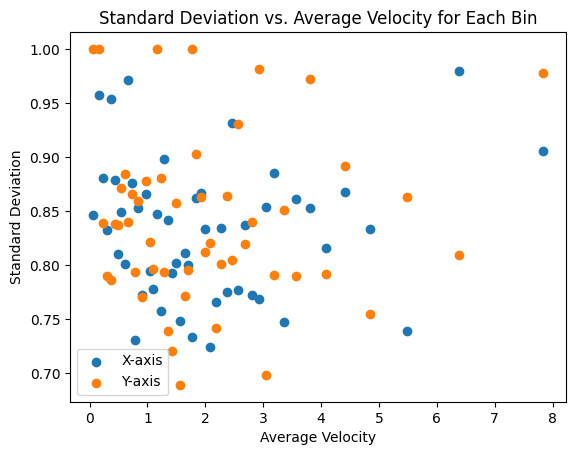

In [397]:
average_velocities = []
for bin in bins:
    avg = 0
    for entry in bin:
        avg += entry[2]
    avg = avg/len(bin)
    average_velocities.append(avg)

# Extract the degrees of freedom and scale parameters for each bin
df_x, loc_x, scale_x, df_y, loc_y, scale_y = zip(*t_params)

df_y = list(df_y)
for i in range(len(df_y)):
    if df_y[i] > 10:
        df_y[i] = 10
df_x = list(df_x)
for i in range(len(df_x)):
    if df_x[i] > 10:
        df_x[i] = 10

# Create a scatter plot
plt.scatter(average_velocities, scale_x, label='X-axis')
plt.scatter(average_velocities, scale_y, label='Y-axis')

plt.title('Standard Deviation vs. Average Velocity for Each Bin')
plt.xlabel('Average Velocity')
plt.ylabel('Standard Deviation')
plt.legend()

plt.show()


In [400]:
X = sm.add_constant(average_velocities)

model = sm.OLS(scale_x, X)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.1004
Date:                Sun, 07 Jan 2024   Prob (F-statistic):              0.753
Time:                        01:39:12   Log-Likelihood:                 67.199
No. Observations:                  50   AIC:                            -130.4
Df Residuals:                      48   BIC:                            -126.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8279      0.015     56.575      0.0